In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt

from atmospheric_deposition_helpers import *

data_path = './Data/'
# load influence functions
fine = xr.open_mfdataset(data_path+'IF.nc')
fine_speciated = xr.open_mfdataset(data_path+'IF_speciated_comp.nc')

# load catchments
catchments = make_catchments_dataset()

/Users/bengeyman/anaconda3/envs/GEOS-Chem/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Overwrite existing file: bilinear_250x1280_91x144.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable Onega as the horizontal dimensions for this dataset.


In [28]:
all_emissions = compile_emissions()
all_emissions.tail()

,Year,AF_Hg0,AF_HgII,AS_Hg0,AS_HgII,EU_Hg0,EU_HgII,NA_Hg0,NA_HgII,SA_Hg0,SA_HgII,Geogenic_Hg0,Ocean_Hg0,Soil_Hg0,Biomass_Burning_Hg0
51,"2,011.0",329.3,104.9,580.0,725.9,66.2,108.7,34.7,70.9,246.9,32.6,250.0,"3,836.0",853.0,321.0
52,"2,012.0",341.0,108.6,590.7,739.3,65.1,107.0,32.5,66.4,247.0,32.6,250.0,"3,836.0",853.0,321.0
53,"2,013.0",339.3,108.0,602.8,754.5,62.7,103.0,31.6,64.6,239.3,31.6,250.0,"3,836.0",853.0,321.0
54,"2,014.0",349.5,111.3,611.1,764.8,60.5,99.4,30.3,62.1,239.8,31.7,250.0,"3,836.0",853.0,321.0
55,"2,015.0",357.1,113.7,621.7,778.0,59.8,98.2,28.0,57.3,243.6,32.2,250.0,"3,836.0",853.0,321.0


In [29]:
deposition, deposition_speciated = make_deposition_fields(all_emissions, fine, fine_speciated)

In [30]:
deposition_table = make_deposition_table(deposition, catchments)

In [31]:
deposition_table

,River,Start Year,End Year,Intercept,$\Delta$ (total change),$\Delta$ (%),Dep. 1970 (Mg yr-1),Dep. 2015 (Mg yr-1)
0,Onega,1980,1992,3.2,-0.5,-15.5,5.0,1.7
1,North Dvina,1980,2001,10.3,-3.1,-30.6,14.9,6.9
2,Mezen,1980,2002,2.2,-0.6,-26.4,3.2,1.6
3,Pechora,1983,2002,9.0,-2.2,-24.7,13.0,6.7
4,Ob,1979,2008,42.1,-10.2,-24.2,55.0,32.2
5,Yenisey,1980,2011,38.6,-8.1,-21.0,52.4,30.4
6,Lena,2004,2011,33.1,1.5,4.5,46.3,35.0
7,Kolyma,1982,1987,12.4,-0.3,-2.8,15.6,12.0


In [32]:
time_series_all = get_timeseries_all(catchments, deposition)
time_series_EU = get_timeseries_EU(catchments, deposition)

0 Onega
1 North Dvina
2 Mezen
3 Pechora
4 Ob
5 Yenisey
6 Lena
7 Kolyma


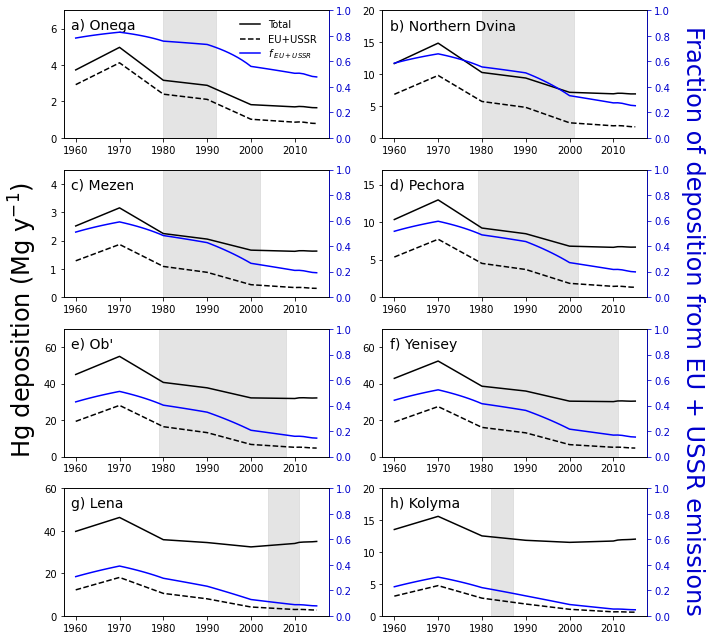

In [33]:
c_ax2 = 'mediumblue'
plot_dict = {'River':['Onega','North Dvina','Mezen','Pechora','Ob','Yenisey','Lena','Kolyma'],
             'Title':['a) Onega','b) Northern Dvina','c) Mezen','d) Pechora','e) Ob\'','f) Yenisey','g) Lena','h) Kolyma'],
             'ylim_low':[0.,0,0,0,0,0,0,0],
             'ylim_high':[7.,20,4.5,17,70,70,60,20],
             'yticks':[[0.,2.,4.,6.], [0,5,10,15,20], [0,1,2,3,4], [0,5,10,15],
                       [0,20,40,60], [0,20,40,60], [0,20,40,60], [0,5,10,15,20]]}

fig = plt.figure(figsize=(9,9))
for count, i in enumerate(plot_dict['River']):
    ax = plt.subplot(int(f'42{count+1}'))
    ax.plot(time_series_all['Year'], time_series_all[i], color='black', label='Total', zorder=2)
    ax.plot(time_series_EU['Year'], time_series_EU[i], color='black', linestyle='--', label='EU+USSR', zorder=2)
    
    ax1 = ax.twinx()
    ax1.plot(time_series_all['Year'], (time_series_EU[i]/time_series_all[i]), 
             color='blue', label='$f_{\ EU+USSR}$', zorder=1)
    ax1.spines['right'].set_color(c_ax2 )
    ax1.yaxis.label.set_color(c_ax2 )
    ax1.tick_params(axis='y', colors=c_ax2 )
    ax1.set_ylim((0,1))

    subset = deposition_table[deposition_table['River']==i]
    if len(subset)>0:
        start_tmp = subset['Start Year'].item()
        end_tmp = subset['End Year'].item()
        if i != 'Pechora':
            ax.axvspan(start_tmp, end_tmp, alpha=0.6, color='lightgrey')
        elif i == 'Pechora':
            ax.axvspan(1979, 2002, alpha=0.6, color='lightgrey')
    
    ax.text(x = 1959, y=(0.85*plot_dict['ylim_high'][count]), s=plot_dict['Title'][count], size=14)
    
    ax.set_ylim((plot_dict['ylim_low'][count], plot_dict['ylim_high'][count]))
    ax.set_yticks(plot_dict['yticks'][count])
    
    print(count, i)
    if count==0:
        ax.legend(loc=(0.65,0.7), frameon=False, fontsize=10)
        ax1.legend(loc=(0.65,0.58), frameon=False, fontsize=10)
fig.text(-0.04, 0.5, 'Hg deposition (Mg y$^{-1}$)', 
         va='center', rotation='vertical', fontsize=24)
fig.text(1.0, 0.5, 'Fraction of deposition from EU + USSR emissions', 
         va='center', rotation=270, color=c_ax2, fontsize=24)
plt.tight_layout()